## Converting detailed morphology into stylized in SWC format
This converting procedure works only for cells with a distal apical dendrite and a tuft.  

#### Function for ploting morphology from swc

In [2]:
from stylized_swc import plot_morphology_swc
%matplotlib notebook

#### Load original swc file

In [1]:
import pandas as pd

# read swc file
swc_file = 'Rorb-IRES2-Cre-D_Ai14-212873.04.01.01_510987644_m.swc'
swc0 = pd.read_csv(swc_file,sep=' ',skiprows=3,names='id,type,x,y,z,r,pid'.split(','),index_col='id')

# plot_morphology_swc(swc0) # plot the original morphology

#### Rotate the cell to align distal apical dendrite with y-axis

In [2]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from sklearn import linear_model

# function calculate rotation that moves source vector to target vector
def rotate_to_align(source,target):
    target = np.asarray(target)
    target = target/np.linalg.norm(target)
    source = np.asarray(source)
    source = source/np.linalg.norm(source)
    rotvec = np.cross(source,target)
    modulus = np.linalg.norm(rotvec)
    if modulus<1e-4:
        rot,_ = R.align_vectors(np.column_stack(target),np.column_stack(source)) # alternative method
    else:
        ang = np.sign(np.vdot(source,target))*(np.arcsin(modulus)-np.pi/2)+np.pi/2
        rot = R.from_rotvec(ang/modulus*rotvec)
    return rot

swc = swc0.copy() # to be written to new file
coor3d = list('xyz')

# children id
swc0['cid'] = [[] for _ in range(len(swc0))]
for i in swc0.index:
    pid = swc0.loc[i,'pid']
    if pid>0:
        swc0.loc[pid,'cid'].append(i)

# distance to soma
soma_id = swc0.index[swc0['type']==1][0] # soma index
soma = swc0.loc[soma_id,coor3d] # soma coordinates
centered_coord = (swc0[coor3d]-soma).astype('float64') # translate soma to the origin
swc0['dist'] = np.linalg.norm(centered_coord,axis=1) # distance to the soma

# find id of the segment of the first branch at distal apical dendrite and choose it as the end point
max_dist = np.max(swc0['dist'])
# search in segment further than half of the furthest segment distance
end_pt_id = swc0.index[((swc0['dist']>max_dist/2) & (len(swc0['cid'])>1) & (swc0['type']==4)).tolist().index(True)]

# rotate the cell to make apical dendrite align with y-axis and write to a new dataframe
cell_orien = np.array([0.,1.,0.]) # target orientation (rotate to align with y-axis)
orien = centered_coord.loc[end_pt_id] # end point orientation
rot2y = rotate_to_align(orien,cell_orien)
swc[coor3d] = rot2y.apply(centered_coord)

# rotate about y axis to put basal dendrites around xy-plane
basal = swc.index[swc['type']==3]
lreg = linear_model.LinearRegression(fit_intercept=False)
lreg.fit(swc.loc[basal,'x'].values.reshape(-1,1),swc.loc[basal,'z'].values.reshape(-1,1))
rot_y = R.from_euler('y',np.arctan(lreg.coef_[0,0]))
swc[coor3d] = rot_y.apply(swc[coor3d])

# The rotation representations below can be read by BMTK
rot = rot_y*rot2y # compose two rotations
print(rot.apply(orien)) # check final end point position after rotation (should be close to [0,y,0])
rot_zyx = rot.as_euler('zyx') # rotation angles around z then y then x 
# quaternion = rot.as_quat() # quaternion representation of rotation

# # save rotated swc file
# rot_file = 'rotate_morphology.swc'
# with open(swc_file,'r') as f:
#     lines = [next(f) for i in range(3)]

# with open(rot_file,'w') as f:
#     for line in lines:
#         f.write(line)
# swc.to_csv(rot_file,sep=' ',header=False,float_format='%.4f',mode='a')

[-1.23900890e-13  3.00013189e+02  7.10542736e-15]


#### Start with the cell below if the swc file of rotated cell is created in previous step.

In [1]:
# import numpy as np
# import pandas as pd

# # read rotated morphology file
# rot_file = 'rotate_morphology.swc'
# swc = pd.read_csv(rot_file,sep=' ',skiprows=3,names='id,type,x,y,z,r,pid'.split(','),index_col='id')

In [5]:
# children id
swc['cid'] = [[] for _ in range(len(swc))]
for i in swc.index:
    pid = swc.loc[i,'pid']
    if pid>0:
        swc.loc[pid,'cid'].append(i)

# distance to soma
coor3d = list('xyz')
soma_id = swc.index[swc['type']==1][0] # soma index
soma = swc.loc[soma_id,coor3d] # soma coordinates
swc['dist'] = np.linalg.norm(swc[coor3d]-soma,axis=1)

# find id of the segment of the first branch at distal apical dendrite and choose it as the end point
max_dist = np.max(swc['dist'])
distal_id = swc.index[swc['dist']>max_dist/2] # search in segment further than half of the furthest segment distance
end_pt_id = distal_id[[(len(seg['cid'])>1) & (seg['type']==4) for _,seg in swc.loc[distal_id].iterrows()].index(True)]

# calculate length of each segment
swc['L'] = np.zeros((len(swc),1))
nonsoma = swc['type'].values>1
swc.loc[swc.index[nonsoma],'L'] = np.linalg.norm(swc.loc[nonsoma,coor3d].values-swc.loc[swc[nonsoma]['pid'],coor3d].values,axis=1)

In [6]:
# function find all chidren given a root segment id
def all_children(df,pid,cids=None):
    if cids is None:
        cids = np.zeros(len(df),dtype=bool)
    for cid in df.loc[pid,'cid']:
        cids[df.index.get_loc(cid)] = True
        all_children(df,cid,cids=cids)
    return cids

In [7]:
# function find all parents till soma given a segment id
def all_parents(df,cid):
    pids = np.zeros(len(df),dtype=bool)
    pid = df.loc[cid,'pid']
    p0id = df.loc[pid,'pid']
    while p0id>0:
        pids[df.index.get_loc(cid)] = True
        cid = pid
        pid = p0id
        p0id = df.loc[p0id,'pid']
    return pids

In [8]:
# find the sections
axon = np.asarray(swc['type']==2)
basal = np.asarray(swc['type']==3)
tuft = all_children(swc,end_pt_id) # bool array
trunk = all_parents(swc,end_pt_id)
apical = np.asarray((swc['type']==4) & (~tuft) & (~trunk))

<IPython.core.display.Javascript object>


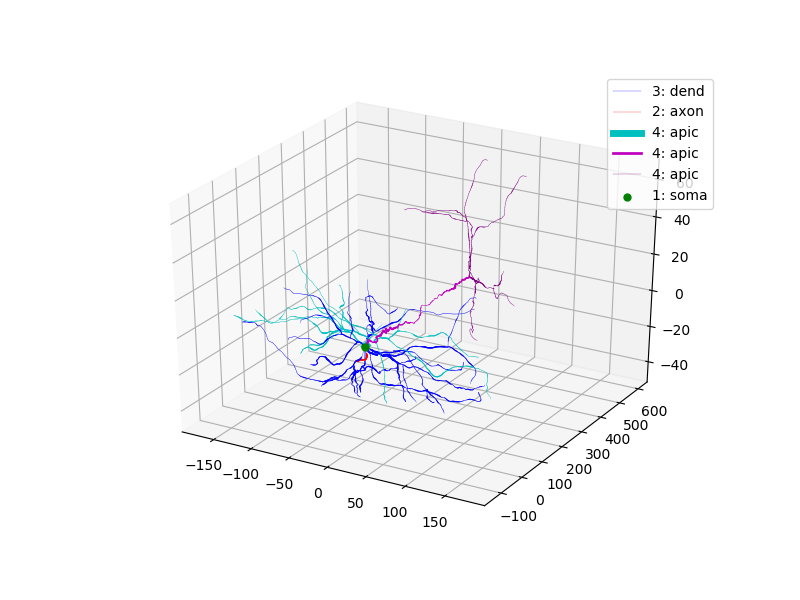

(<Figure size 800x600 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x248068cf108>)

In [9]:
# plot tuft
fig,ax = plot_morphology_swc(swc,child_idx=~(tuft|trunk))
plot_morphology_swc(swc,child_idx=trunk,root_id=soma_id,ax=ax,clr=['g','r','b','m'])
plot_morphology_swc(swc,child_idx=tuft,root_id=end_pt_id,ax=ax,clr=['g','r','b','purple'])

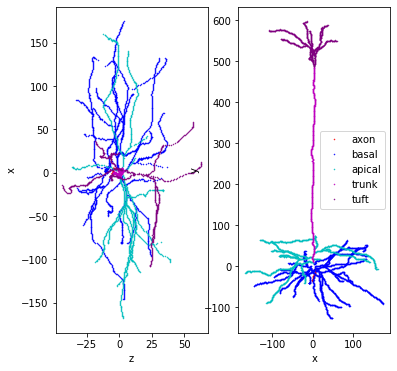

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(6,6))
plt.subplot(121)
plt.plot(swc.loc[axon,'z'],swc.loc[axon,'x'],'r.',label='axon',markersize=1)
plt.plot(swc.loc[basal,'z'],swc.loc[basal,'x'],'b.',label='basal',markersize=1)
plt.plot(swc.loc[apical,'z'],swc.loc[apical,'x'],'c.',label='apical',markersize=1)
plt.plot(swc.loc[trunk,'z'],swc.loc[trunk,'x'],'m.',label='trunk',markersize=1)
plt.plot(swc.loc[tuft,'z'],swc.loc[tuft,'x'],'.',color='purple',label='tuft',markersize=1)
plt.xlabel('z')
plt.ylabel('x')
plt.subplot(122)
plt.plot(swc.loc[axon,'x'],swc.loc[axon,'y'],'r.',label='axon',markersize=1)
plt.plot(swc.loc[basal,'x'],swc.loc[basal,'y'],'b.',label='basal',markersize=1)
plt.plot(swc.loc[apical,'x'],swc.loc[apical,'y'],'c.',label='apical',markersize=1)
plt.plot(swc.loc[trunk,'x'],swc.loc[trunk,'y'],'m.',label='trunk',markersize=1)
plt.plot(swc.loc[tuft,'x'],swc.loc[tuft,'y'],'.',color='purple',label='tuft',markersize=1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=0)

In [11]:
# section properties: idx-index in swc, r,c-reach,center in 3d, axial-single branch along axial,
# L-length of each branch, R-radius, ang-elevation angle of branch, L_scale-Length scaling factor
sec_prop = pd.DataFrame(np.zeros((5,4)),columns=['L','R','ang','L_scale'])
sec_prop.insert(0,'name',['axon','basal','apical','trunk','tuft'])
sec_prop.insert(1,'idx',[axon,basal,apical,trunk,tuft])
sec_prop.insert(2,'r',[np.zeros(3) for _ in range(len(sec_prop))])
sec_prop.insert(3,'c',[np.zeros(3) for _ in range(len(sec_prop))])
sec_prop.insert(4,'axial',np.array([1,0,0,1,0]).astype(bool))

In [12]:
# reach of dendrite sections and center coordinate along each axis in 3d
def reach(swc,idx):
    r = []
    c = []
    for i,x in enumerate(list('xyz')):
        Max = swc.loc[idx,x].max()
        Min = swc.loc[idx,x].min()
        r.append((Max-Min)/2)
        c.append((Max+Min)/2)
    return r, c

ndcm = 3 # decimal number
for _,sec in sec_prop.iterrows():
    sec['r'][:], sec['c'][:] = np.around(reach(swc,sec['idx']),ndcm)

In [13]:
# geometry of sections
idx = sec_prop.index[sec_prop['name']=='axon'][0]
sec_prop.loc[idx,'ang'] = -np.pi/2
sec_prop.loc[idx,'L'] = sec_prop.loc[idx,'r'][1]-sec_prop.loc[idx,'c'][1]

idx = sec_prop.index[sec_prop['name']=='basal'][0]
sec_prop.loc[idx,'ang'] = np.arctan((sec_prop.loc[idx,'c'][1]-sec_prop.loc[idx,'r'][1])/sec_prop.loc[idx,'r'][0])
sec_prop.loc[idx,'L'] = sec_prop.loc[idx,'r'][0]/np.cos(sec_prop.loc[idx,'ang'])

idx = sec_prop.index[sec_prop['name']=='apical'][0]
sec_prop.loc[idx,'ang'] = 0.
sec_prop.loc[idx,'L'] = sec_prop.loc[idx,'r'][0]

idx = sec_prop.index[sec_prop['name']=='trunk'][0]
sec_prop.loc[idx,'ang'] = np.pi/2
sec_prop.loc[idx,'L'] = sec_prop.loc[idx,'c'][1]+sec_prop.loc[idx,'r'][1]

idx = sec_prop.index[sec_prop['name']=='tuft'][0]
sec_prop.loc[idx,'ang'] = np.arctan(2*sec_prop.loc[idx,'r'][1]/sec_prop.loc[idx,'r'][0])
sec_prop.loc[idx,'L'] = sec_prop.loc[idx,'r'][0]/np.cos(sec_prop.loc[idx,'ang'])

sec_prop['L'] = np.around(sec_prop['L'],ndcm)

In [14]:
# average radius of each type: direct average, consistent membrane area, consistent axial resistance, consistant length constant
radius = lambda swc,idx: (swc.loc[idx,'r'].mean(),
      np.dot(swc.loc[idx,'r'],swc.loc[idx,'L'])/np.sum(swc.loc[idx,'L']),
      (np.sum(swc.loc[idx,'L'])/np.dot(swc.loc[idx,'r']**(-2),swc.loc[idx,'L']))**.5,
      (np.sum(swc.loc[idx,'L'])/np.dot(swc.loc[idx,'r']**(-.5),swc.loc[idx,'L']))**2 )

for i,sec in sec_prop.iterrows():
    r = list(radius(swc,sec['idx']))
    if sec['axial']:
        r[-1] *= (sec['L']/np.sum(swc.loc[sec['idx'],'L']))**.5
    r = np.around(r,ndcm)
    sec_prop.loc[i,'R'] = r[-1]
    print(r)

# Length scaling factor to maintain total membrane area
for i,sec in sec_prop.iterrows():
    sec_prop.loc[i,'L_scale'] = np.around(np.dot(swc.loc[sec['idx'],'r'],swc.loc[sec['idx'],'L'])/(sec['R']*sec['L']),ndcm)

sec_prop

[0.513 0.448 0.234 0.324]
[0.279 0.277 0.213 0.242]
[0.251 0.261 0.197 0.22 ]
[0.367 0.37  0.262 0.31 ]
[0.193 0.193 0.165 0.176]


,name,idx,r,c,axial,L,R,ang,L_scale
0,axon,"[False, False, False, False, False, False, Fal...","[4.081, 14.324, 1.371]","[1.097, -20.284, -4.315]",True,34.608,0.324,-1.570796,1.559
1,basal,"[False, True, True, True, True, True, True, Tr...","[160.289, 94.451, 35.09]","[14.241, -31.295, 1.765]",False,203.727,0.242,-0.665215,13.290
2,apical,"[False, False, False, False, False, False, Fal...","[163.95, 81.237, 37.945]","[-3.67, -6.872, 1.366]",False,163.950,0.220,0.000000,9.602
3,trunk,"[False, False, False, False, False, False, Fal...","[5.309, 237.799, 4.007]","[-0.132, 248.974, -0.668]",True,486.773,0.310,1.570796,1.215
4,tuft,"[False, False, False, False, False, False, Fal...","[83.073, 54.632, 53.316]","[-24.555, 541.989, 9.474]",False,137.258,0.176,0.920738,6.117


In [15]:
geo_prop = pd.DataFrame(data=[['soma',True,0.,swc.loc[soma_id,'r'],0.]],columns=['name','axial', 'L', 'R', 'ang'])
geo_prop = pd.concat([geo_prop, sec_prop[['name','axial', 'L', 'R', 'ang']]],ignore_index=True)
geo_prop.index.name = 'id'
geo_prop.insert(1,'type',[1,2,3,4,4,4])
geo_prop.insert(len(geo_prop.columns),'pid',[0,0,0,0,0,4])
geo_prop.to_csv('geom_parameters.csv')
geo_prop

,name,type,axial,L,R,ang,pid
id,,,,,,,
0,soma,1,True,0.000,6.6606,0.000000,0
1,axon,2,True,34.608,0.3240,-1.570796,0
2,basal,3,False,203.727,0.2420,-0.665215,0
3,apical,4,False,163.950,0.2200,0.000000,0
4,trunk,4,True,486.773,0.3100,1.570796,0
5,tuft,4,False,137.258,0.1760,0.920738,4


In [17]:
from stylized_swc import gen_stylized_swc

styl = gen_stylized_swc(geo_prop)
styl

,type,x,y,z,r,pid
id,,,,,,
1,1,0.000000,0.000000,0.0,6.6606,-1
2,2,0.000000,-4.944000,0.0,0.3240,1
3,2,0.000000,-9.888000,0.0,0.3240,2
4,2,0.000000,-14.832000,0.0,0.3240,3
5,2,0.000000,-19.776000,0.0,0.3240,4
...,...,...,...,...,...,...
306,4,-71.205454,580.427891,0.0,0.1760,305
307,4,-74.172348,584.330178,0.0,0.1760,306
308,4,-77.139242,588.232465,0.0,0.1760,307


In [18]:
styl_file = 'stylized.swc'
with open(styl_file,'w') as f:
    f.write('# id,type,x,y,z,r,pid\n')
styl.to_csv(styl_file,sep=' ',header=False,float_format='%.4f',mode='a')

In [19]:
import numpy as np
import pandas as pd

styl_file = 'stylized.swc'
styl = pd.read_csv(styl_file,sep=' ',skiprows=1,names='id,type,x,y,z,r,pid'.split(','),index_col='id')
styl

,type,x,y,z,r,pid
id,,,,,,
1,1,0.0000,0.0000,0.0,6.6606,-1
2,2,0.0000,-4.9440,0.0,0.3240,1
3,2,0.0000,-9.8880,0.0,0.3240,2
4,2,0.0000,-14.8320,0.0,0.3240,3
5,2,0.0000,-19.7760,0.0,0.3240,4
...,...,...,...,...,...,...
306,4,-71.2055,580.4279,0.0,0.1760,305
307,4,-74.1723,584.3302,0.0,0.1760,306
308,4,-77.1392,588.2325,0.0,0.1760,307


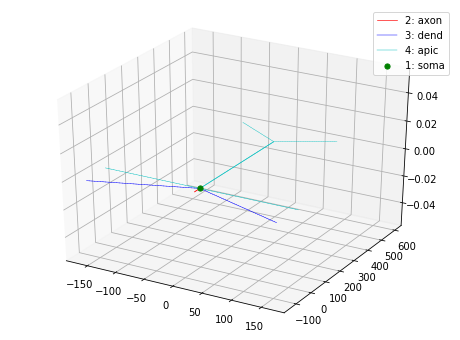

In [20]:
fig,ax = plot_morphology_swc(styl)